In [1]:
from DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from Visualiser import collateVisGCN, Visualiser, VisualiseDataset
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params

In [5]:
@dataclass
class Args:
    receptive_field = 10
    framerate = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    num_detections = 15
    chunk_size = 60
    batch_size = 32
    input_channel = 10
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    evaluation_frequency=20
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    loss_weight_segmentation=1.0
    loss_weight_detection=0.0
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 8
    K_parameters = torch.FloatTensor([
                                    [-10,-20,-20,-10,-20,-10,-10,-20], 
                                    [-5,-10,-10,-5,-10,-5,-5,-10], 
                                    [5,10,10,5,10,5,5,10], 
                                    [10,20,20,10,20,10,10,20]
                                    ])

# Grid Search Train 

In [6]:
args = Args
collate_fn = collateGCN

for i, chunk_size in enumerate(np.arange(10,60,10)):

    # Set manually parameters 
    receptive_field = 0.2 * chunk_size

    K_vals = [
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        ]
    
    K_LIST = []
    for K in range(4):
        # multiplier = -1 if K in range(2) else 1
        if K==0:
            list_param = [-K_vals[ann][0] for ann in range(len(K_vals))]
        elif K==1:
            list_param = [-K_vals[ann][1] for ann in range(len(K_vals))]
        elif K==2:
            list_param = [K_vals[ann][1] for ann in range(len(K_vals))]
        else:
            list_param = [K_vals[ann][0] for ann in range(len(K_vals))]
        K_LIST.append(list_param)

    K_PARAMS = torch.FloatTensor(K_LIST)

    args.K_parameters = K_PARAMS
    args.chunk_size = chunk_size
    args.receptive_field = receptive_field
    print(args)

    train_dataset = CALFData(split="train", args=args)
    validation_dataset = CALFData(split="validate", args=args)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

    validate_loader = torch.utils.data.DataLoader(validation_dataset,
                batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    
    model = ContextAwareModel(num_classes=args.annotation_nr, args=args)
    criterion_segmentation = ContextAwareLoss(K=train_dataset.K_parameters)
    criterion_spotting = SpottingLoss(lambda_coord=args.lambda_coord, lambda_noobj=args.lambda_noobj)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                                betas=(0.9, 0.999), eps=1e-07, 
                                weight_decay=0, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

    losses = trainer(train_loader, validate_loader,
                        model, optimizer, scheduler, 
                        [criterion_segmentation, criterion_spotting], 
                        [args.loss_weight_segmentation, args.loss_weight_detection],
                        model_name=args.model_name,
                        max_epochs=args.max_epochs, evaluation_frequency=args.evaluation_frequency,
                        save_dir=f"models/gridsearch{i}.pth.tar")

    with open(f'results/gridsearch{i}_results.pkl', 'wb') as file:
        pickle.dump(losses, file)

<class '__main__.Args'>


Get labels & features: 100%|██████████| 2/2 [00:03<00:00,  1.84s/it]
Train 1: Time 0.375s (it:0.381s) Data:0.077s (it:0.078s) Loss 5.8187e+03 : 100%|████████████████████████████████████████████████| 57/57 [00:21<00:00,  2.67it/s]
Evaluate 1: Time 0.232s (it:0.209s) Data:0.094s (it:0.076s) Loss 5.2943e+03 : 100%|█████████████████████████████████████████████| 57/57 [00:13<00:00,  4.31it/s]
Train 2: Time 0.378s (it:0.382s) Data:0.077s (it:0.076s) Loss 5.3806e+03 : 100%|████████████████████████████████████████████████| 57/57 [00:21<00:00,  2.65it/s]
Evaluate 2: Time 0.232s (it:0.212s) Data:0.093s (it:0.077s) Loss 4.8845e+03 : 100%|█████████████████████████████████████████████| 57/57 [00:13<00:00,  4.30it/s]
Train 3: Time 0.376s (it:0.361s) Data:0.077s (it:0.076s) Loss 5.0546e+03 : 100%|████████████████████████████████████████████████| 57/57 [00:21<00:00,  2.66it/s]
Evaluate 3: Time 0.233s (it:0.217s) Data:0.093s (it:0.077s) Loss 4.3993e+03 : 100%|███████████████████████████████████████████

<class '__main__.Args'>


Get labels & features: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]
Train 1: Time 0.721s (it:0.713s) Data:0.165s (it:0.149s) Loss 1.1065e+04 : 100%|████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.39it/s]
Evaluate 1: Time 0.415s (it:0.403s) Data:0.165s (it:0.148s) Loss 8.3790e+03 : 100%|█████████████████████████████████████████████| 57/57 [00:23<00:00,  2.41it/s]
Train 2: Time 0.720s (it:0.730s) Data:0.165s (it:0.149s) Loss 1.0166e+04 : 100%|████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.39it/s]
Evaluate 2: Time 0.434s (it:0.396s) Data:0.182s (it:0.148s) Loss 8.7500e+03 : 100%|█████████████████████████████████████████████| 57/57 [00:24<00:00,  2.30it/s]
Train 3: Time 0.725s (it:0.724s) Data:0.165s (it:0.148s) Loss 9.5654e+03 : 100%|████████████████████████████████████████████████| 57/57 [00:41<00:00,  1.38it/s]
Evaluate 3: Time 0.415s (it:0.382s) Data:0.165s (it:0.148s) Loss 9.0768e+03 : 100%|███████████████████████████████████████████

<class '__main__.Args'>


Get labels & features: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
Train 1: Time 1.058s (it:1.105s) Data:0.240s (it:0.223s) Loss 1.5893e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:00<00:00,  1.06s/it]
Evaluate 1: Time 0.613s (it:0.596s) Data:0.255s (it:0.223s) Loss 1.6294e+04 : 100%|█████████████████████████████████████████████| 57/57 [00:34<00:00,  1.63it/s]
Train 2: Time 1.074s (it:1.165s) Data:0.256s (it:0.227s) Loss 1.4525e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/it]
Evaluate 2: Time 0.615s (it:0.574s) Data:0.256s (it:0.222s) Loss 1.3544e+04 : 100%|█████████████████████████████████████████████| 57/57 [00:35<00:00,  1.63it/s]
Train 3: Time 1.071s (it:1.034s) Data:0.256s (it:0.223s) Loss 1.3589e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:01<00:00,  1.07s/it]
Evaluate 3: Time 0.598s (it:0.586s) Data:0.239s (it:0.223s) Loss 1.3767e+04 : 100%|███████████████████████████████████████████

<class '__main__.Args'>


Get labels & features: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]
Train 1: Time 1.554s (it:1.672s) Data:0.344s (it:0.314s) Loss 2.0389e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:28<00:00,  1.55s/it]
Evaluate 1: Time 0.880s (it:0.833s) Data:0.342s (it:0.311s) Loss 1.6328e+04 : 100%|█████████████████████████████████████████████| 57/57 [00:50<00:00,  1.14it/s]
Train 2: Time 1.609s (it:1.550s) Data:0.363s (it:0.310s) Loss 1.8579e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:31<00:00,  1.61s/it]
Evaluate 2: Time 0.894s (it:0.794s) Data:0.342s (it:0.300s) Loss 1.6625e+04 : 100%|█████████████████████████████████████████████| 57/57 [00:50<00:00,  1.12it/s]
Train 3: Time 1.606s (it:1.481s) Data:0.362s (it:0.303s) Loss 1.7342e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:31<00:00,  1.61s/it]
Evaluate 3: Time 0.908s (it:0.834s) Data:0.345s (it:0.310s) Loss 1.6356e+04 : 100%|███████████████████████████████████████████

<class '__main__.Args'>


Get labels & features: 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]
Train 1: Time 1.824s (it:1.801s) Data:0.429s (it:0.375s) Loss 2.4618e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:43<00:00,  1.82s/it]
Evaluate 1: Time 1.010s (it:0.942s) Data:0.422s (it:0.370s) Loss 2.2748e+04 : 100%|█████████████████████████████████████████████| 57/57 [00:57<00:00,  1.01s/it]
Train 2: Time 1.795s (it:1.798s) Data:0.425s (it:0.373s) Loss 2.2235e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:42<00:00,  1.79s/it]
Evaluate 2: Time 1.014s (it:0.970s) Data:0.422s (it:0.369s) Loss 2.2797e+04 : 100%|█████████████████████████████████████████████| 57/57 [00:57<00:00,  1.01s/it]
Train 3: Time 1.805s (it:1.766s) Data:0.427s (it:0.372s) Loss 2.0760e+04 : 100%|████████████████████████████████████████████████| 57/57 [01:42<00:00,  1.81s/it]
Evaluate 3: Time 1.006s (it:0.985s) Data:0.422s (it:0.369s) Loss 2.1131e+04 : 100%|███████████████████████████████████████████

In [14]:
args = Args
collate_fn = collateVisGCN
mAP_combined = np.empty((0, args.annotation_nr+1))

for i, chunk_size in enumerate(np.arange(10,70,10)):

    # Set manually parameters 
    receptive_field = 0.2 * chunk_size

    K_vals = [
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.2*chunk_size, 0.1*chunk_size),
        (0.4*chunk_size, 0.2*chunk_size),
        ]
    
    K_LIST = []
    for K in range(4):
        # multiplier = -1 if K in range(2) else 1
        if K==0:
            list_param = [-K_vals[ann][0] for ann in range(len(K_vals))]
        elif K==1:
            list_param = [-K_vals[ann][1] for ann in range(len(K_vals))]
        elif K==2:
            list_param = [K_vals[ann][1] for ann in range(len(K_vals))]
        else:
            list_param = [K_vals[ann][0] for ann in range(len(K_vals))]
        K_LIST.append(list_param)

    K_PARAMS = torch.FloatTensor(K_LIST)

    args.K_parameters = K_PARAMS
    args.chunk_size = chunk_size
    args.receptive_field = receptive_field

    model_path = f"models/gridsearch{i}.pth.tar"
    model = torch.load(model_path)
    visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
    mAP = np.expand_dims(visualiser.calculate_MAP(), axis=0)
    mAP_combined = np.concatenate((mAP_combined, mAP), axis=0)

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.21s/it]


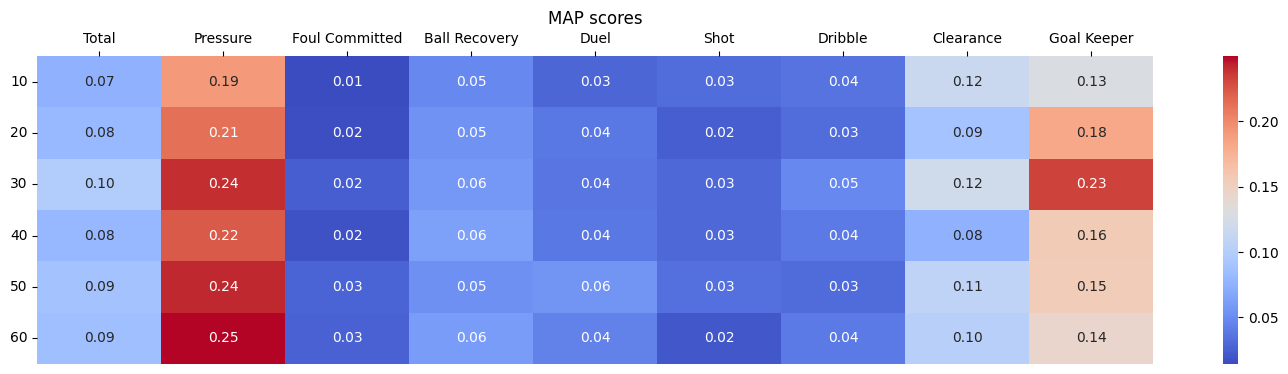

In [15]:
cols = ["Total"] + list(event_enc.keys())
rows = ["10", "20", "30", "40", "50", "60"]

plt.figure(figsize=(18, 4))
plt.title("MAP scores")
ax = sns.heatmap(mAP_combined, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)

ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()

ax.set_yticklabels(rows, rotation=0)

plt.show()

In [8]:
chunk_size=30
# Set manually parameters 
receptive_field = 0.2 * chunk_size

K_vals = [
    (0.2*chunk_size, 0.1*chunk_size),
    (0.4*chunk_size, 0.2*chunk_size),
    (0.4*chunk_size, 0.2*chunk_size),
    (0.2*chunk_size, 0.1*chunk_size),
    (0.4*chunk_size, 0.2*chunk_size),
    (0.2*chunk_size, 0.1*chunk_size),
    (0.2*chunk_size, 0.1*chunk_size),
    (0.4*chunk_size, 0.2*chunk_size),
    ]

K_LIST = []
for K in range(4):
    # multiplier = -1 if K in range(2) else 1
    if K==0:
        list_param = [-K_vals[ann][0] for ann in range(len(K_vals))]
    elif K==1:
        list_param = [-K_vals[ann][1] for ann in range(len(K_vals))]
    elif K==2:
        list_param = [K_vals[ann][1] for ann in range(len(K_vals))]
    else:
        list_param = [K_vals[ann][0] for ann in range(len(K_vals))]
    K_LIST.append(list_param)

K_PARAMS = torch.FloatTensor(K_LIST)

args.chunk_size = chunk_size
args.receptive_field = receptive_field

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


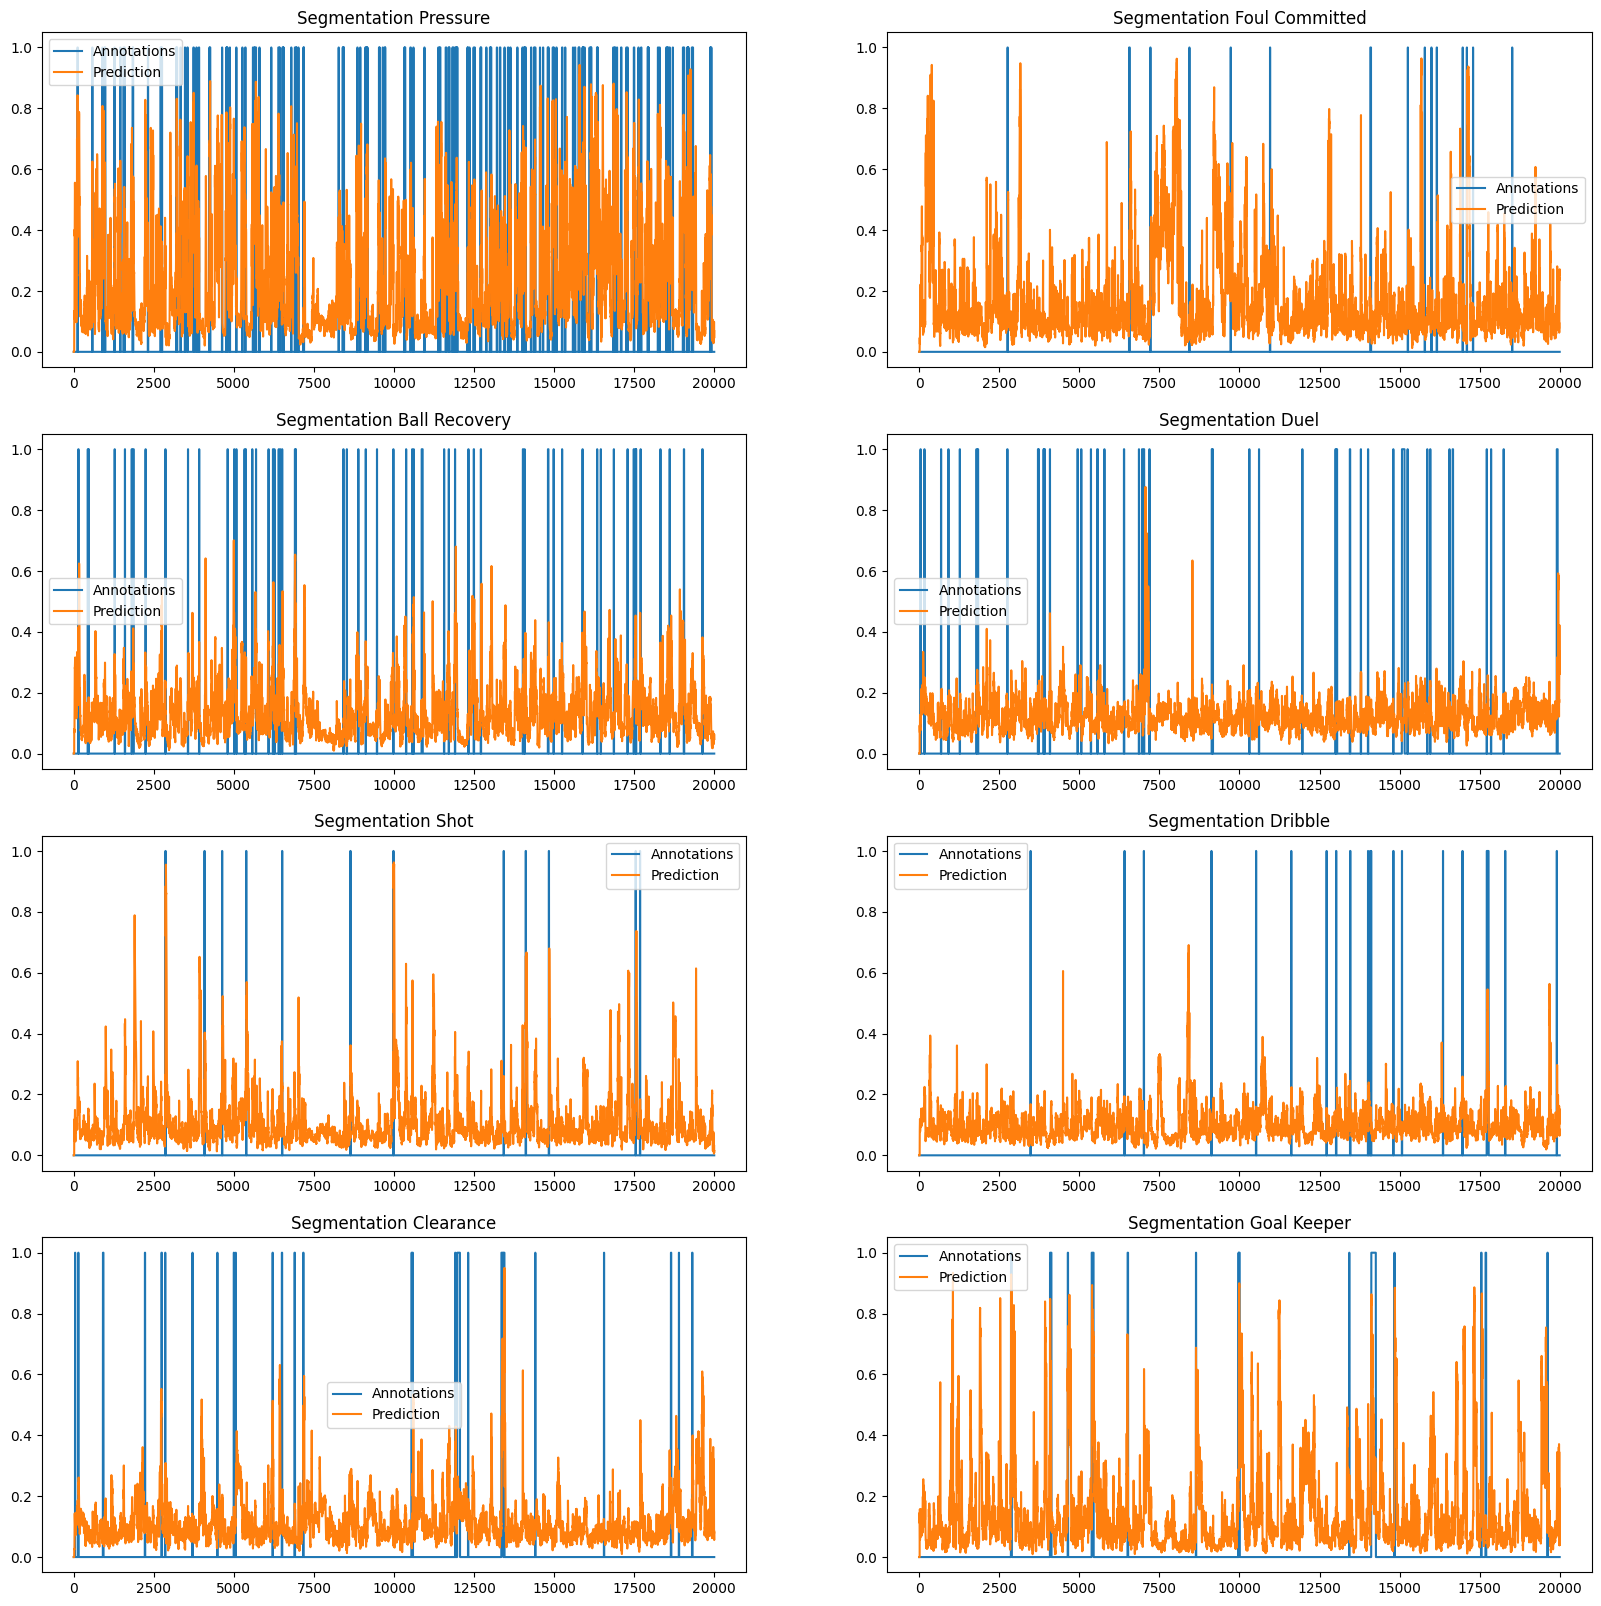

In [12]:
collate_fn = collateVisGCN
model_path = f"models/gridsearch{2}.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

In [2]:
@dataclass
class Args:
    receptive_field = 6
    framerate = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    num_detections = 15
    chunk_size = 30
    batch_size = 32
    input_channel = 10
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    evaluation_frequency=20
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    loss_weight_segmentation=1.0
    loss_weight_detection=0.0
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 1
    K_parameters = get_K_params(chunk_size)
    focused_annotation = "Pressure"

Data preprocessing: 100%|██████████| 1/1 [00:14<00:00, 14.88s/it]


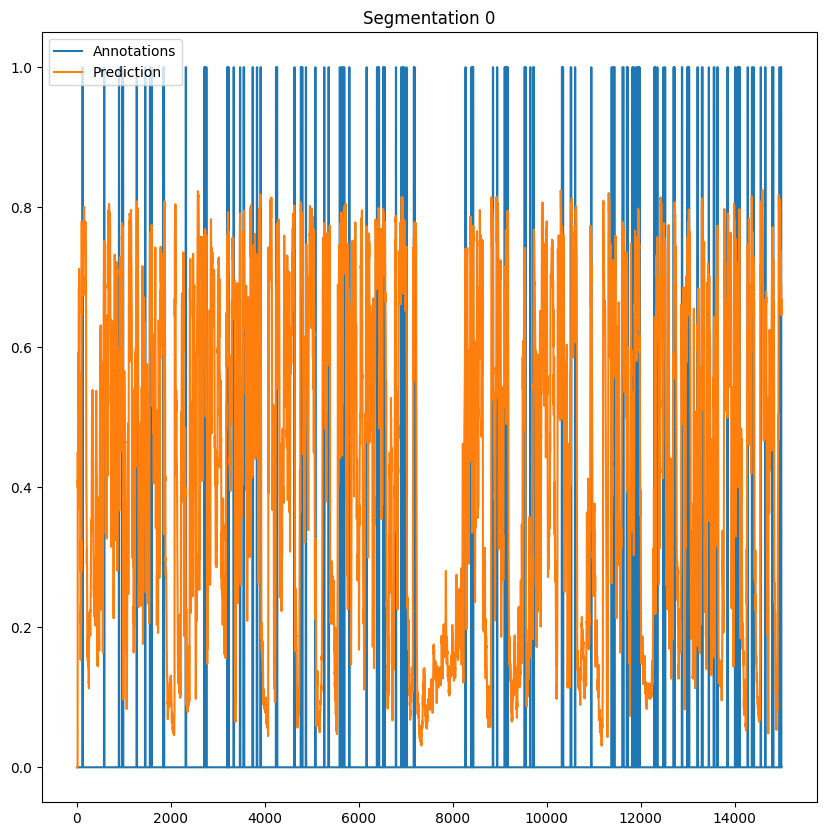

In [3]:
args = Args
collate_fn = collateVisGCN
model_path = "models/detector_Pressure.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, ann=8)
visualiser.plot_predictions(frame_threshold=15000, save_dir="plots/PredictionsPlot.png", annotation="Pressure")

In [4]:
from sklearn.metrics import average_precision_score

average_precision_score(visualiser.annotations[:,event_enc["Pressure"]], visualiser.segmentation[:28575,0], average='macro')

0.19879100244385034

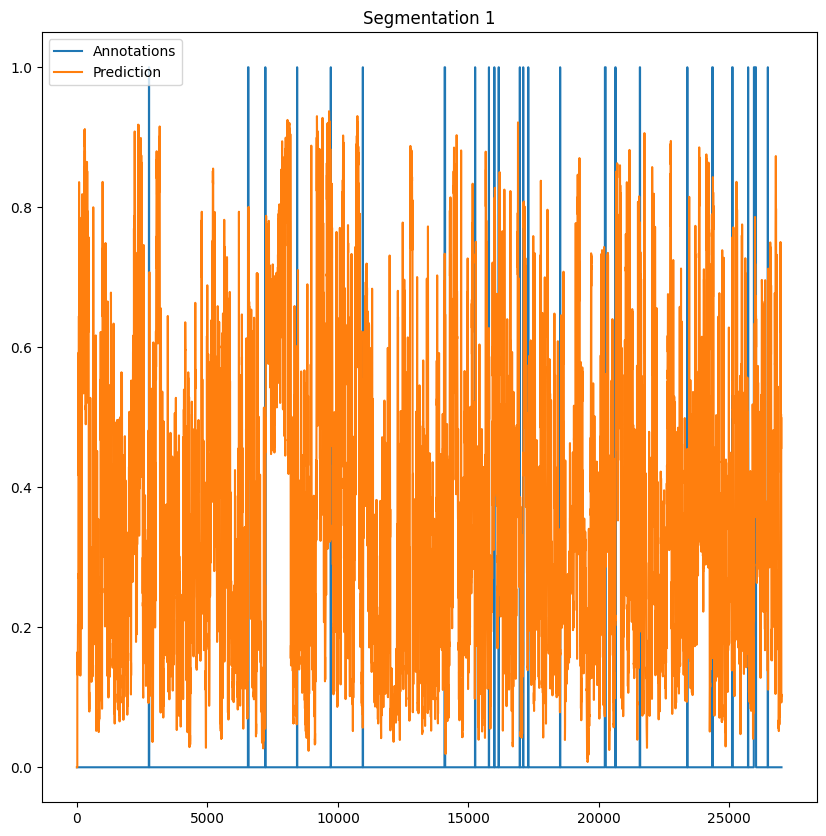

In [10]:
# args = Args
# args.focused_annotation = "Foul Committed"
# collate_fn = collateVisGCN
# model_path = "models/detector_Foul Committed.pth.tar"
# model = torch.load(model_path)
# visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, ann=8)
visualiser.plot_predictions(frame_threshold=27000, save_dir="plots/PredictionsPlot.png", annotation="Foul Committed")

In [7]:
from sklearn.metrics import average_precision_score
average_precision_score(visualiser.annotations[:,event_enc["Foul Committed"]], visualiser.segmentation[:28575,0], average='macro')

0.014047084801572268

Data preprocessing: 100%|██████████| 1/1 [00:17<00:00, 17.64s/it]


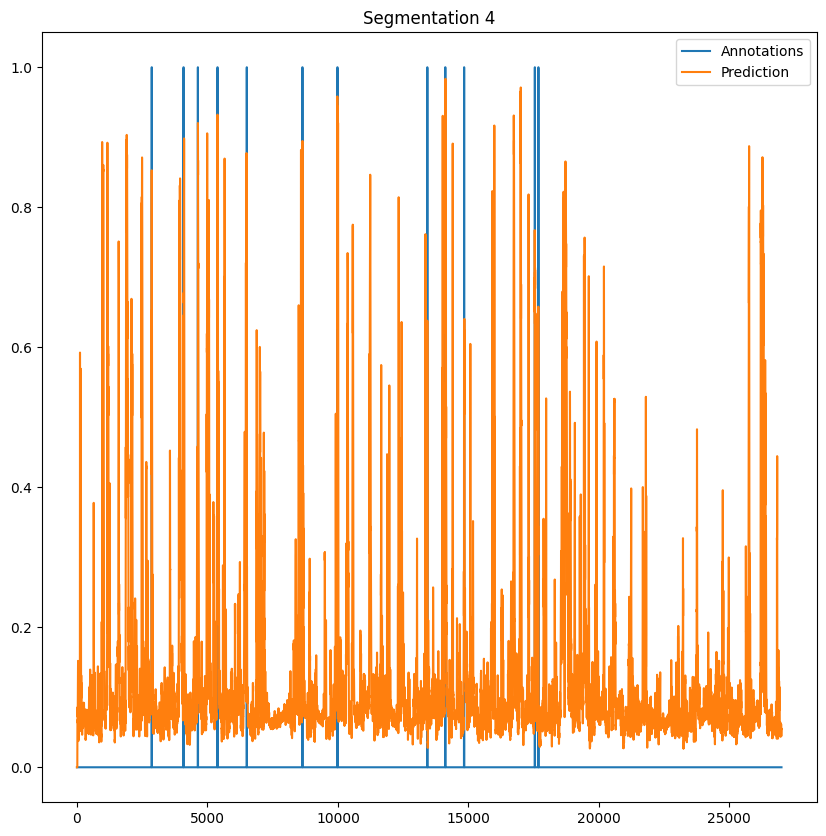

In [11]:
args = Args
args.focused_annotation = "Shot"
collate_fn = collateVisGCN
model_path = "models/detector_Shot.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, ann=8)
visualiser.plot_predictions(frame_threshold=27000, save_dir="plots/PredictionsPlot.png", annotation="Shot")

In [12]:
from sklearn.metrics import average_precision_score
average_precision_score(visualiser.annotations[:,event_enc["Foul Committed"]], visualiser.segmentation[:28575,0], average='macro')

0.011504280632446693

TypeError: 'Figure' object is not subscriptable

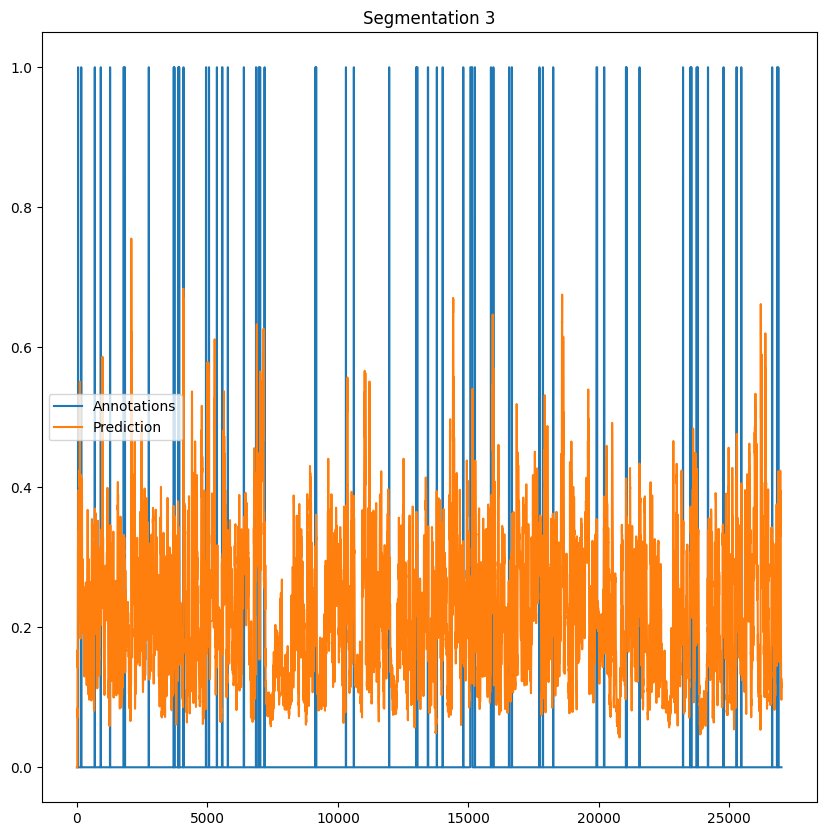

In [5]:
fig = visualiser.plot_predictions(frame_threshold=27000, save_dir="plots/PredictionsPlot.png", annotation=ann)
fig[0]

Data preprocessing: 100%|██████████| 1/1 [00:14<00:00, 14.86s/it]


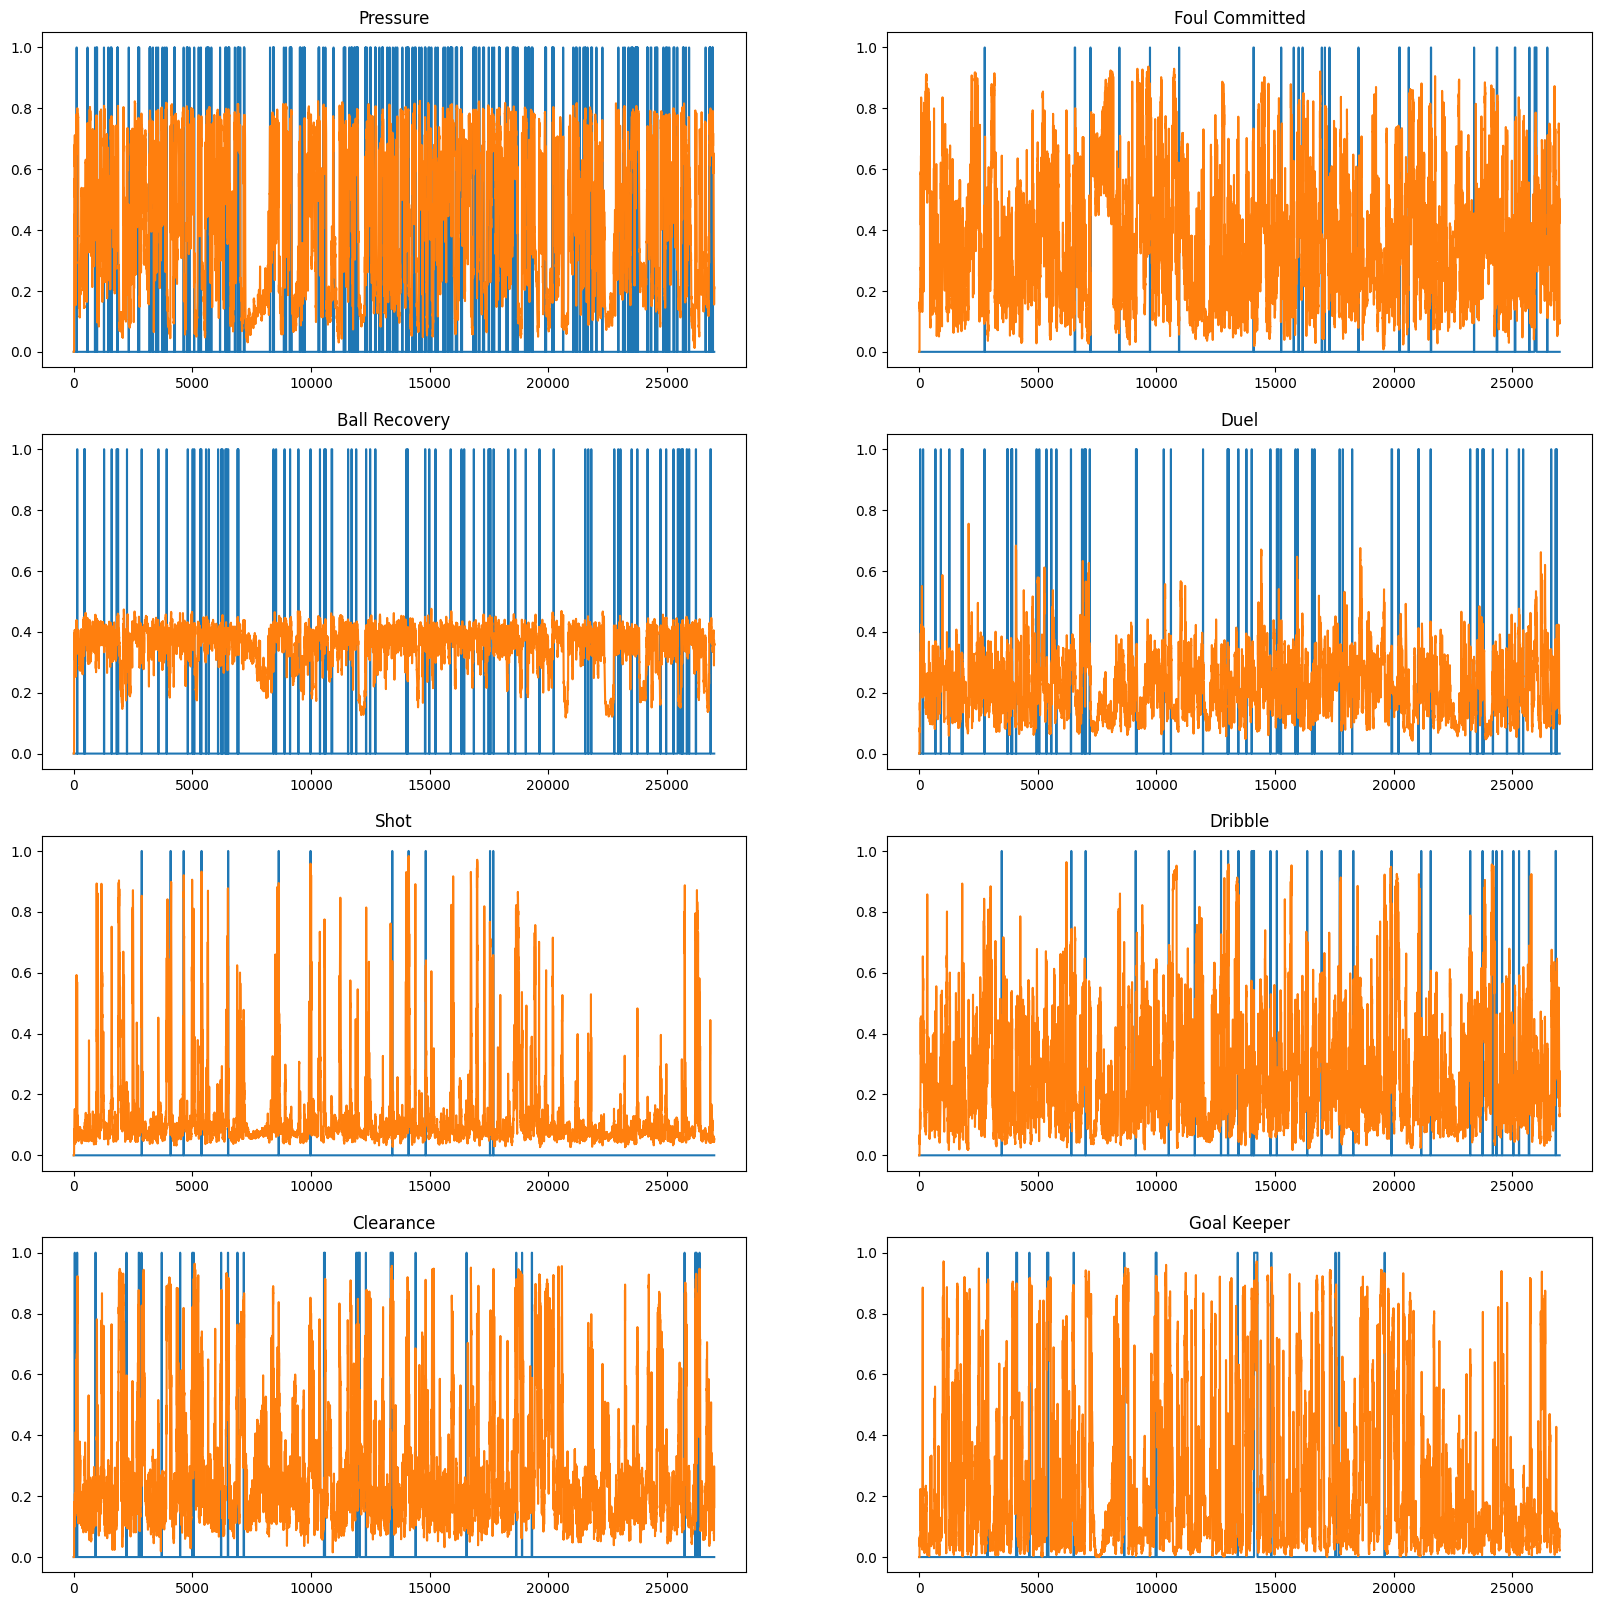

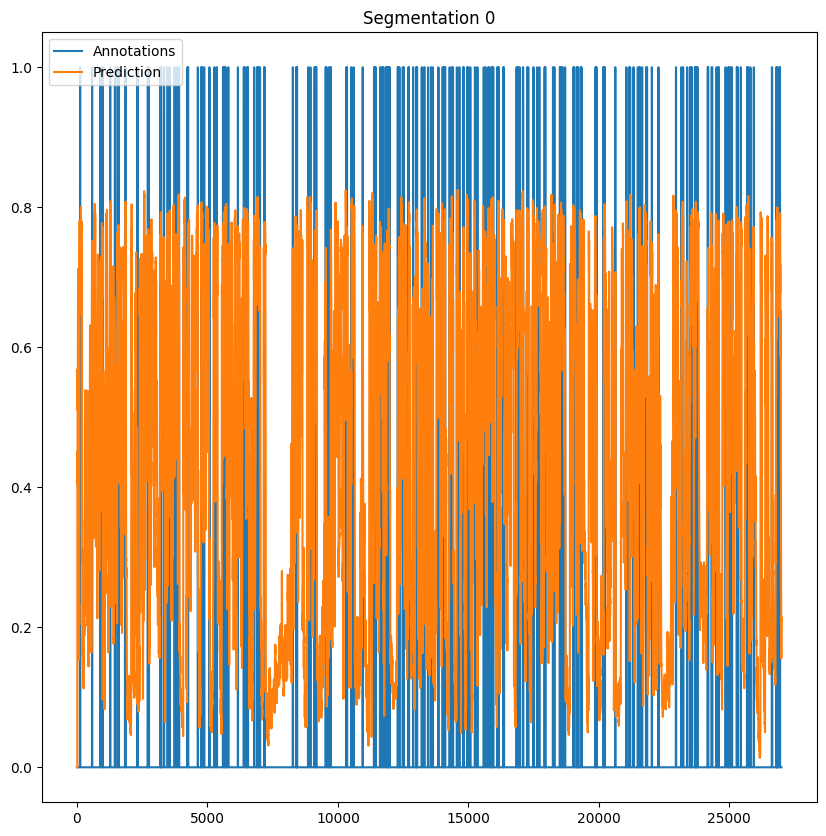

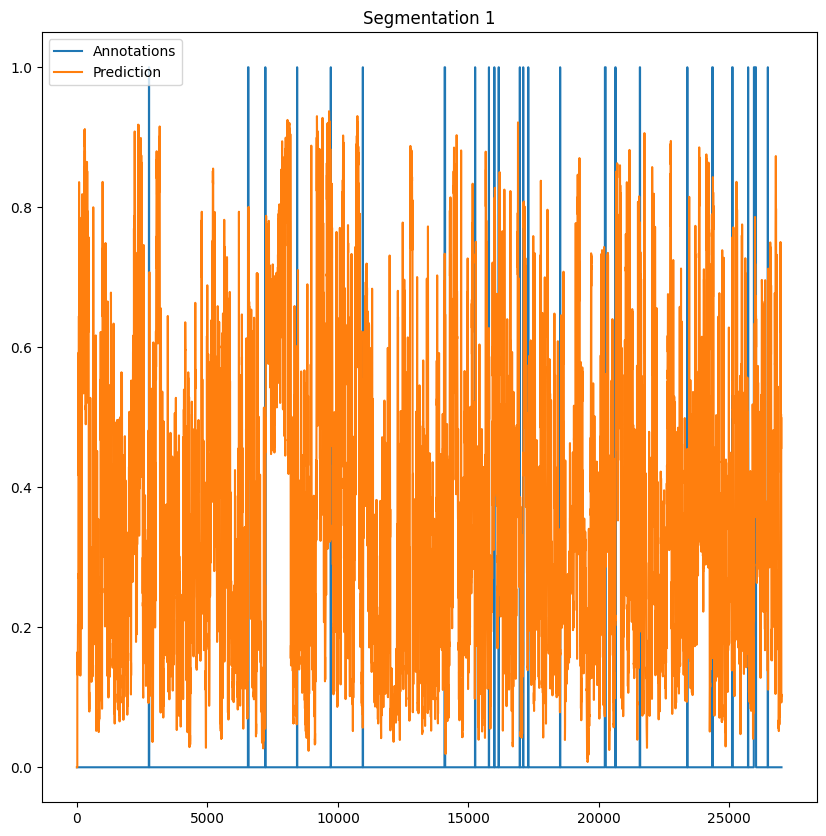

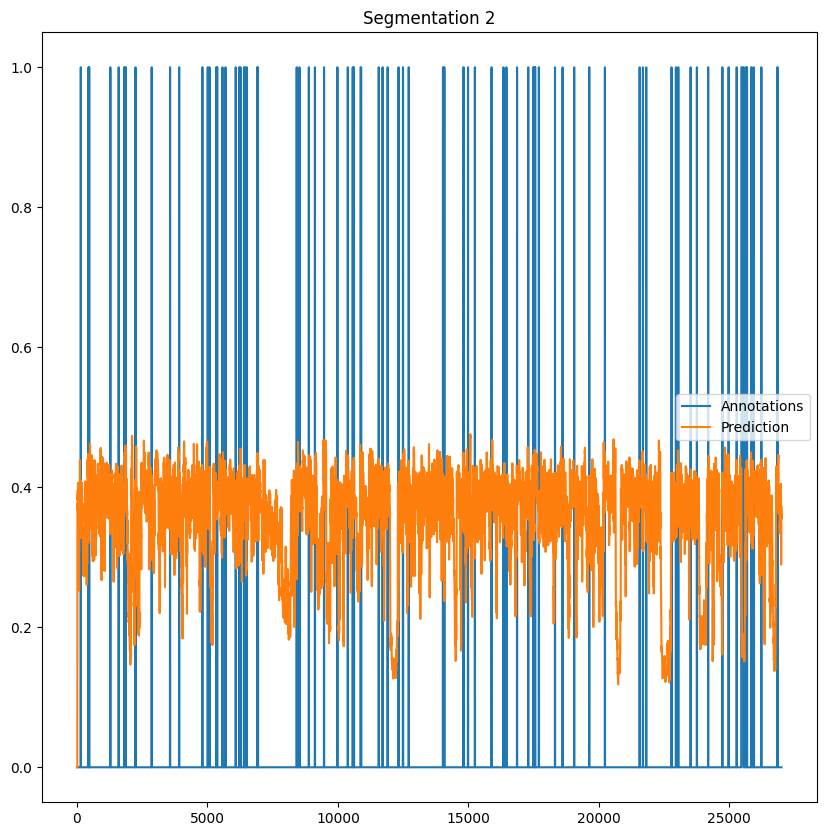

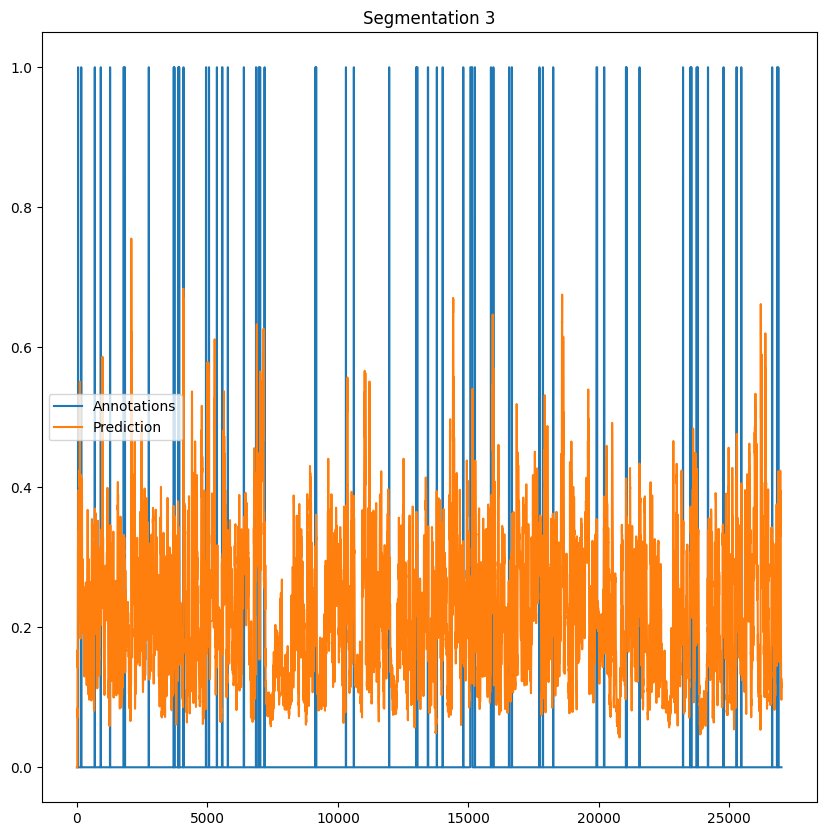

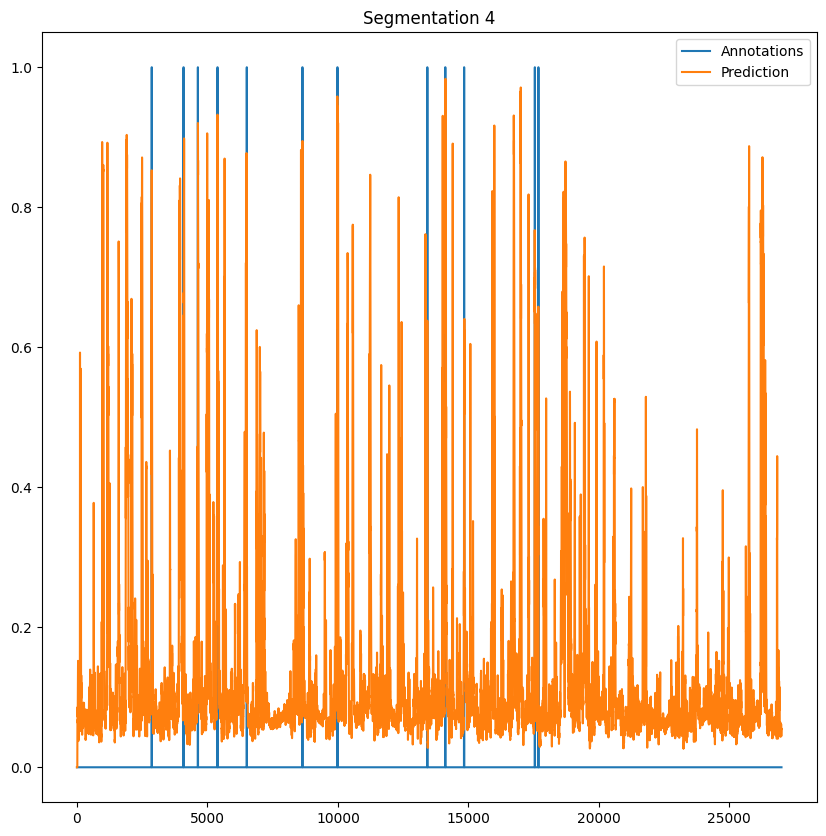

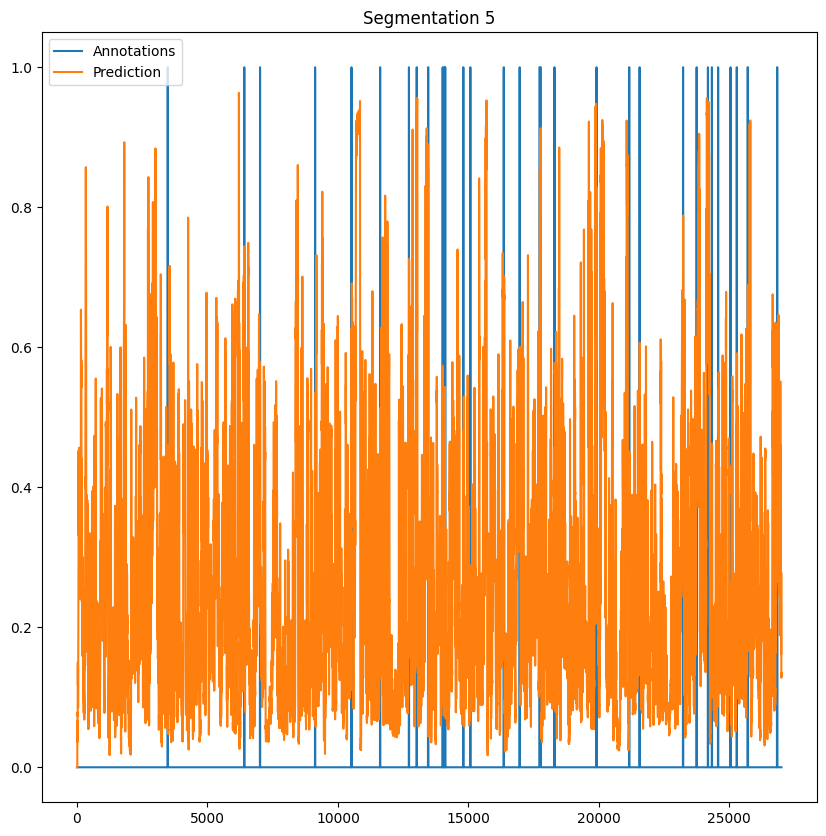

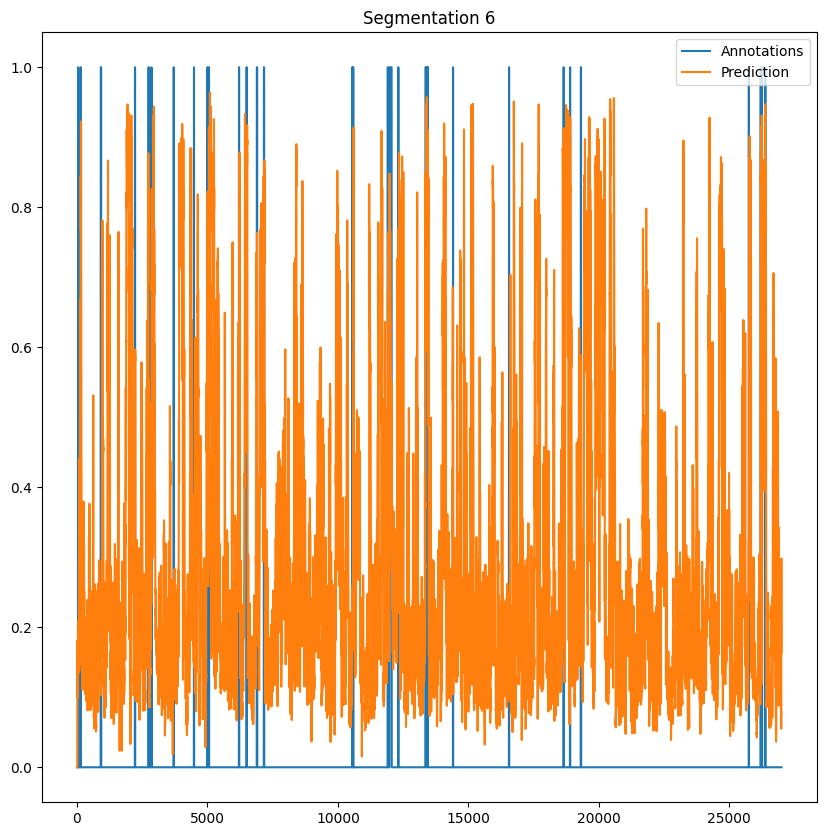

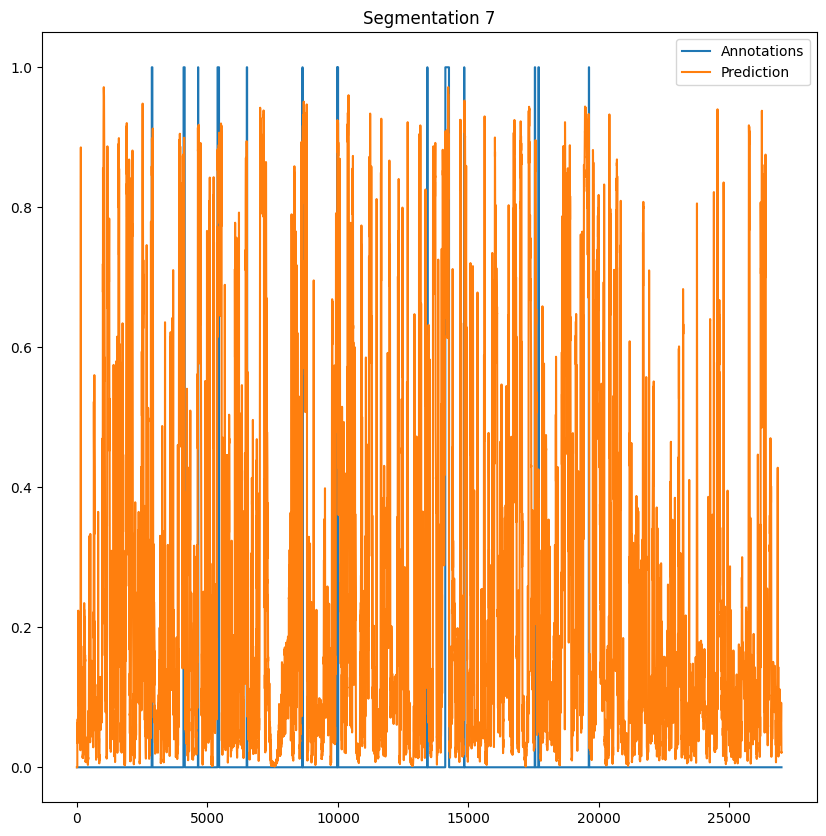

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes_flattened = axes.flatten()

for i, ann in enumerate(event_enc.keys()):
    args = Args
    args.focused_annotation = ann

    collate_fn = collateVisGCN
    model_path = f"models/detector_{ann}.pth.tar"
    model = torch.load(model_path)

    visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, ann=8)
    fig, ax = visualiser.plot_predictions(frame_threshold=27000, save_dir="plots/PredictionsPlot.png", annotation=ann)
    
    axes_flattened[i].plot(ax.get_lines()[0].get_xdata(), ax.get_lines()[0].get_ydata())
    axes_flattened[i].plot(ax.get_lines()[1].get_xdata(), ax.get_lines()[1].get_ydata())
    axes_flattened[i].set_title(ann)

plt.show()

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.48s/it]


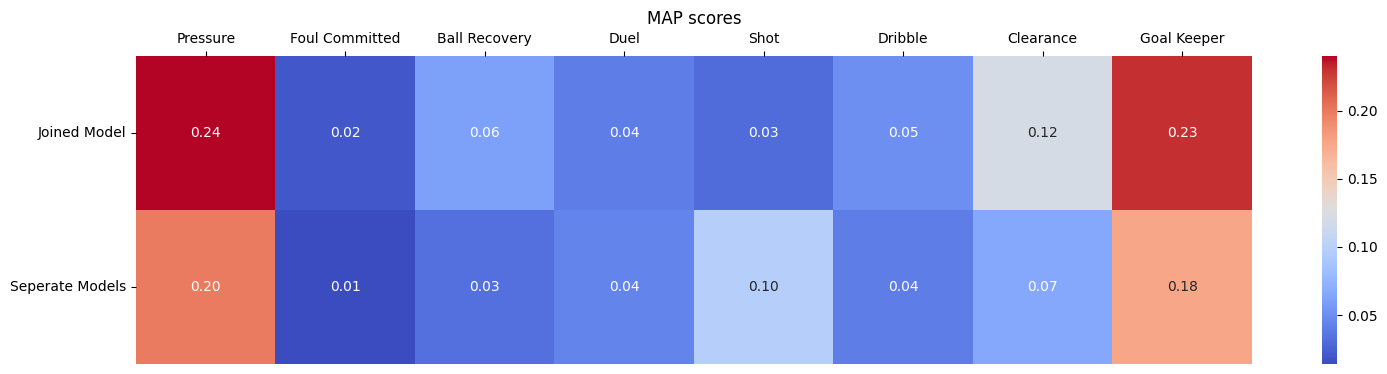

In [18]:
from sklearn.metrics import average_precision_score

original_mAP_scores = [0.24,0.02,0.06,0.04,0.03,0.05,0.12,0.23]
mAP_scores = []
for i, ann in enumerate(event_enc.keys()):
    args = Args
    args.focused_annotation = ann

    collate_fn = collateVisGCN
    model_path = f"models/detector_{ann}.pth.tar"
    model = torch.load(model_path)

    visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, ann=8)
    mAP_scores.append(average_precision_score(visualiser.annotations[:,event_enc[ann]], visualiser.segmentation[:28575,0], average='macro'))

merged_scores = []
merged_scores.append(original_mAP_scores)
merged_scores.append(mAP_scores)

plt.figure(figsize=(18, 4))
plt.title("MAP scores")
ax = sns.heatmap(merged_scores, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)

ax.set_xticklabels(list(event_enc.keys()), rotation=0)
ax.xaxis.tick_top()

ax.set_yticklabels(["Joined Model", "Seperate Models"], rotation=0)

plt.show()

In [ ]:
files = find_files("../football_games")
dataset = DatasetPreprocessor(1/5, files[1].name)
dataset._open_dataset(files[1].datafile, files[1].metafile, files[1].annotatedfile)
player_violation = dataset._generate_node_features()
dataset.generate_heatmaps()